# Milestone 1: Customer Purchase Likelihood Prediction Model
## Group 7 - Machine Learning and Predictive Analytics

**Building on:** Feature Engineering work from previous milestone  
**Algorithm:** Random Forest Regression  
**Objective:** Predict customer's likelihood of making a purchase (0-1 scale)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [2]:
# Load the pre-engineered features created previously
print("Loading engineered features from previous activity...\n")

features_data = pd.read_csv('features_top30_scaled.csv')
transactions = pd.read_csv('transactions_data_cleaned.csv')

print(f" Features dataset loaded: {features_data.shape[0]:,} rows × {features_data.shape[1]} columns")
print(f" Transactions dataset loaded: {transactions.shape[0]:,} rows")
print(f"\nFeatures data info:")
print(f"  Data type: {type(features_data)}")
print(f"  Shape: {features_data.shape}")

Loading engineered features from previous activity...

 Features dataset loaded: 5,818 rows × 34 columns
 Transactions dataset loaded: 5,818 rows

Features data info:
  Data type: <class 'pandas.core.frame.DataFrame'>
  Shape: (5818, 34)


In [4]:
print("\n" + "*"*80)
print("ENGINEERED FEATURES DATASET")
print("*"*80)
print(f"\nFirst few rows:")
print(features_data.head())


********************************************************************************
ENGINEERED FEATURES DATASET
********************************************************************************

First few rows:
   Transaction_ID  Company_ID  Product_ID  CustomerProductAffinity  \
0               1          88           6                -0.831813   
1               2          29          19                 0.789873   
2               4          85          12                 0.161977   
3               5          47           3                -0.680327   
4               6          80          11                -1.239306   

   PricePerUnit  RelativePurchaseSize  Product_Price_prod  \
0     -0.395984             -0.458952            1.079744   
1     -0.582869             -0.269786           -1.018856   
2     -0.636572             -0.466677           -1.298669   
3     -0.593610             -0.699645           -0.878949   
4      0.108105             -0.955703            0.520117   

   P

In [5]:
print(f"\nColumn names and data types:")
print(features_data.dtypes)


Column names and data types:
Transaction_ID                 int64
Company_ID                     int64
Product_ID                     int64
CustomerProductAffinity      float64
PricePerUnit                 float64
RelativePurchaseSize         float64
Product_Price_prod           float64
Product_TotalQuantitySold    float64
Product_AvgQuantity          float64
Product_StdRevenue           float64
Product_StdQuantity          float64
Product_AvgRevenue           float64
Product_TotalRevenue         float64
Product_TotalSales           float64
Product_PopularityRank       float64
Product_MarketShare          float64
Quantity                     float64
Product_UniqueCustomers      float64
RelativeQuantity             float64
IsHighValueTransaction         int64
Product_Price_trans          float64
IsBulkPurchase                 int64
DiscountAmount               float64
ProductPenetrationRate       float64
Customer_MaxSpending         float64
Customer_MinSpending         float64
Customer

In [6]:
print(f"\nMissing values check:")
missing = features_data.isnull().sum()
if missing.sum() == 0:
    print("No missing values - data is clean!")
else:
    print(f"  Missing values found:\n{missing[missing > 0]}")


Missing values check:
No missing values - data is clean!


In [7]:
print(f"\nBasic statistics:")
print(features_data.describe())


Basic statistics:
       Transaction_ID   Company_ID   Product_ID  CustomerProductAffinity  \
count     5818.000000  5818.000000  5818.000000             5.818000e+03   
mean      5022.861636    52.627191    10.310588             8.548984e-18   
std       2895.396827    28.663851     5.905825             1.000086e+00   
min          1.000000     1.000000     1.000000            -1.783461e+00   
25%       2529.500000    27.000000     5.000000            -8.252011e-01   
50%       5050.500000    54.500000    10.000000            -1.237555e-02   
75%       7521.500000    78.000000    15.000000             8.294598e-01   
max       9997.000000   100.000000    20.000000             1.899199e+00   

       PricePerUnit  RelativePurchaseSize  Product_Price_prod  \
count  5.818000e+03          5.818000e+03        5.818000e+03   
mean  -2.418141e-16          1.221283e-18       -3.480658e-16   
std    1.000086e+00          1.000086e+00        1.000086e+00   
min   -1.409890e+00         -1.58516

In [8]:
print("\n" + "*"*80)
print("TRANSACTIONS DATASET")
print("*"*80)
print(f"\nFirst few rows:")
print(transactions.head())
print(f"\nColumn names and data types:")
print(transactions.dtypes)


********************************************************************************
TRANSACTIONS DATASET
********************************************************************************

First few rows:
   Transaction_ID  Company_ID  Product_ID  Quantity Transaction_Date  \
0               1          88           6      10.0       2024-03-26   
1               2          29          19      16.0       2024-07-09   
2               4          85          12      12.0       2023-09-06   
3               5          47           3       8.0       2021-07-06   
4               6          80          11       4.0       2021-07-12   

   Product_Price  Total_Cost  
0      194379.15   1075200.0  
1       97930.99   1428000.0  
2      130556.44   1008000.0  
3       99575.61    705600.0  
4      160658.68    627200.0  

Column names and data types:
Transaction_ID        int64
Company_ID            int64
Product_ID            int64
Quantity            float64
Transaction_Date     object
Product_Pr

In [9]:
print("\n" + "*"*80)
print("CREATING TARGET VARIABLE: PURCHASE LIKELIHOOD")
print("*"*80)

# Calculate purchase frequency for each customer (Company_ID)
purchase_counts = transactions.groupby('Company_ID').size().reset_index(name='purchase_count')

print(f"\nPurchase frequency statistics:")
print(purchase_counts['purchase_count'].describe())

# Normalize to 0-1 scale
min_purchases = purchase_counts['purchase_count'].min()
max_purchases = purchase_counts['purchase_count'].max()

purchase_counts['purchase_likelihood'] = (
    (purchase_counts['purchase_count'] - min_purchases) / 
    (max_purchases - min_purchases)
)

print(f"\nNormalization details:")
print(f"  Min purchases: {min_purchases}")
print(f"  Max purchases: {max_purchases}")
print(f"  Likelihood range: 0.0 to 1.0")

print(f"\nPurchase likelihood distribution:")
print(purchase_counts['purchase_likelihood'].describe())


********************************************************************************
CREATING TARGET VARIABLE: PURCHASE LIKELIHOOD
********************************************************************************

Purchase frequency statistics:
count    90.000000
mean     64.644444
std       8.585736
min      42.000000
25%      59.000000
50%      63.500000
75%      70.000000
max      87.000000
Name: purchase_count, dtype: float64

Normalization details:
  Min purchases: 42
  Max purchases: 87
  Likelihood range: 0.0 to 1.0

Purchase likelihood distribution:
count    90.000000
mean      0.503210
std       0.190794
min       0.000000
25%       0.377778
50%       0.477778
75%       0.622222
max       1.000000
Name: purchase_likelihood, dtype: float64


In [10]:
# Verify alignment
print(f"\nTarget variable created:")
print(f"  Customers with likelihood targets: {len(purchase_counts)}")
print(f"  Customers in features dataset: {len(features_data)}")

# Check if Company_ID exists in features_data
if 'Company_ID' in features_data.columns:
    print(f"  Company_ID column found in features dataset!")
else:
    print(f"  ⚠ Company_ID not in features - checking for identifier column...")
    print(f"  Available columns: {features_data.columns.tolist()[:10]}...")  # Show first 10


Target variable created:
  Customers with likelihood targets: 90
  Customers in features dataset: 5818
  Company_ID column found in features dataset!


In [11]:
# Aggregate features to customer level (Company_ID)
# Taking the mean of all features across all transactions for each customer
print("Aggregating features to customer level...")

features_by_customer = features_data.groupby('Company_ID').mean().reset_index()

print(f"✓ Features aggregated to customer level: {features_by_customer.shape[0]:,} customers")
print(f"  Original rows: {features_data.shape[0]:,} transactions")
print(f"  Aggregated rows: {features_by_customer.shape[0]:,} customers")

# Now merge with target variable
model_data = features_by_customer.merge(
    purchase_counts[['Company_ID', 'purchase_likelihood']], 
    on='Company_ID', 
    how='inner'
)

print(f"\n✓ Merged dataset created:")
print(f"  Shape: {model_data.shape[0]:,} rows × {model_data.shape[1]} columns")
print(f"  All customers matched: {len(model_data) == len(features_by_customer)}")

Aggregating features to customer level...
✓ Features aggregated to customer level: 90 customers
  Original rows: 5,818 transactions
  Aggregated rows: 90 customers

✓ Merged dataset created:
  Shape: 90 rows × 35 columns
  All customers matched: True


In [12]:
# Separate features (X) and target (y)
# Exclude Company_ID and purchase_likelihood from features
X = model_data.drop(columns=['Company_ID', 'purchase_likelihood'])
y = model_data['purchase_likelihood']

print(f"Feature matrix (X):")
print(f"  Shape: {X.shape[0]:,} rows × {X.shape[1]} columns")
print(f"  All numeric: {X.dtypes.apply(lambda x: x in ['int64', 'float64']).all()}")

print(f"\nTarget variable (y):")
print(f"  Shape: {y.shape[0]:,} samples")
print(f"  Data type: {y.dtype}")
print(f"  Range: {y.min():.4f} to {y.max():.4f}")

print(f"\nFeature list ({X.shape[1]} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

Feature matrix (X):
  Shape: 90 rows × 33 columns
  All numeric: True

Target variable (y):
  Shape: 90 samples
  Data type: float64
  Range: 0.0000 to 1.0000

Feature list (33 total):
   1. Transaction_ID
   2. Product_ID
   3. CustomerProductAffinity
   4. PricePerUnit
   5. RelativePurchaseSize
   6. Product_Price_prod
   7. Product_TotalQuantitySold
   8. Product_AvgQuantity
   9. Product_StdRevenue
  10. Product_StdQuantity
  11. Product_AvgRevenue
  12. Product_TotalRevenue
  13. Product_TotalSales
  14. Product_PopularityRank
  15. Product_MarketShare
  16. Quantity
  17. Product_UniqueCustomers
  18. RelativeQuantity
  19. IsHighValueTransaction
  20. Product_Price_trans
  21. IsBulkPurchase
  22. DiscountAmount
  23. ProductPenetrationRate
  24. Customer_MaxSpending
  25. Customer_MinSpending
  26. CustomerProduct_Count
  27. Season_Encoded
  28. Day
  29. DiscountPercentage
  30. Customer_LastPurchaseDay
  31. Customer_TotalQuantity
  32. DayOfWeek
  33. Total_Cost


In [13]:
# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train-Test Split (80-20):")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Testing set: {X_test.shape[0]:,} samples")
print(f"  Total: {len(X):,} samples")

print(f"\nTarget distribution:")
print(f"  Training y - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"  Testing y  - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")

Train-Test Split (80-20):
  Training set: 72 samples
  Testing set: 18 samples
  Total: 90 samples

Target distribution:
  Training y - Mean: 0.5012, Std: 0.1872
  Testing y  - Mean: 0.5111, Std: 0.2101


In [15]:
print("\n" + "*"*80)
print("TRAINING RANDOM FOREST REGRESSION MODEL")
print("*"*80)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,           # Number of decision trees
    max_depth=15,               # Maximum depth of each tree
    min_samples_split=5,        # Min samples required to split a node
    min_samples_leaf=2,         # Min samples required at leaf node
    random_state=42,            # For reproducibility
    n_jobs=-1                   # Use all available processors
)

print(f"\nModel hyperparameters:")
print(f"  n_estimators: 100")
print(f"  max_depth: 15")
print(f"  min_samples_split: 5")
print(f"  min_samples_leaf: 2")
print(f"  random_state: 42")


********************************************************************************
TRAINING RANDOM FOREST REGRESSION MODEL
********************************************************************************

Model hyperparameters:
  n_estimators: 100
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  random_state: 42


In [16]:
# Here is where we train the model
print(f"\nTraining model on {X_train.shape[0]:,} samples...")
rf_model.fit(X_train, y_train)
print(f"Model training completed!")


Training model on 72 samples...
Model training completed!


In [17]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print(f"Predictions generated:")
print(f"  Training predictions shape: {y_train_pred.shape}")
print(f"  Testing predictions shape: {y_test_pred.shape}")

print(f"\nSample predictions (first 10 test samples):")
for i in range(min(10, len(y_test_pred))):
    print(f"  Actual: {y_test.iloc[i]:.4f} → Predicted: {y_test_pred[i]:.4f}")

Predictions generated:
  Training predictions shape: (72,)
  Testing predictions shape: (18,)

Sample predictions (first 10 test samples):
  Actual: 0.6000 → Predicted: 0.6277
  Actual: 0.6222 → Predicted: 0.6443
  Actual: 0.6222 → Predicted: 0.6547
  Actual: 0.8222 → Predicted: 0.7392
  Actual: 0.2444 → Predicted: 0.2740
  Actual: 0.5111 → Predicted: 0.5109
  Actual: 0.0000 → Predicted: 0.1995
  Actual: 0.4000 → Predicted: 0.3902
  Actual: 0.6667 → Predicted: 0.6754
  Actual: 0.3333 → Predicted: 0.3844


In [19]:
# Calculate evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "*"*80)
print("MODEL PERFORMANCE EVALUATION")
print("*"*80)

print(f"\nTRAINING SET METRICS:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE:     {train_rmse:.4f}")
print(f"  MAE:      {train_mae:.4f}")

print(f"\nTESTING SET METRICS:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE:     {test_rmse:.4f}")
print(f"  MAE:      {test_mae:.4f}")


********************************************************************************
MODEL PERFORMANCE EVALUATION
********************************************************************************

TRAINING SET METRICS:
  R² Score: 0.9597
  RMSE:     0.0373
  MAE:      0.0243

TESTING SET METRICS:
  R² Score: 0.8886
  RMSE:     0.0681
  MAE:      0.0506


In [ ]:
# Create metrics summary
metrics_df = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE', 'MAE'],
    'Training': [train_r2, train_rmse, train_mae],
    'Testing': [test_r2, test_rmse, test_mae]
})

print("\nMetrics Comparison:")
print(metrics_df.to_string(index=False))

# Interpretation
print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
print(f"R² Score: Explains {test_r2*100:.2f}% of variance in purchase likelihood")
print(f"MAE: On average, predictions off by ±{test_mae:.4f} on 0-1 scale")
print(f"RMSE: Root mean squared error is {test_rmse:.4f}")

In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "*"*80)
print("FEATURE IMPORTANCE RANKING")
print("*"*80)
print(f"\nTop 15 most important features for purchase likelihood prediction:\n")
for idx, row in feature_importance.head(15).iterrows():
    bar_length = int(row['importance'] * 50)
    bar = '█' * bar_length
    print(f"{row['feature']:30s} {bar} {row['importance']:.4f}")


********************************************************************************
FEATURE IMPORTANCE RANKING
********************************************************************************

Top 15 most important features for purchase likelihood prediction:

Customer_TotalQuantity         █████████████████████████████████████ 0.7510
CustomerProduct_Count          ███ 0.0701
ProductPenetrationRate         ███ 0.0612
IsBulkPurchase                  0.0190
Quantity                        0.0166
Customer_LastPurchaseDay        0.0106
CustomerProductAffinity         0.0092
Transaction_ID                  0.0058
Day                             0.0046
Total_Cost                      0.0044
Product_Price_trans             0.0044
RelativeQuantity                0.0041
Customer_MinSpending            0.0041
Product_UniqueCustomers         0.0035
Product_StdQuantity             0.0033


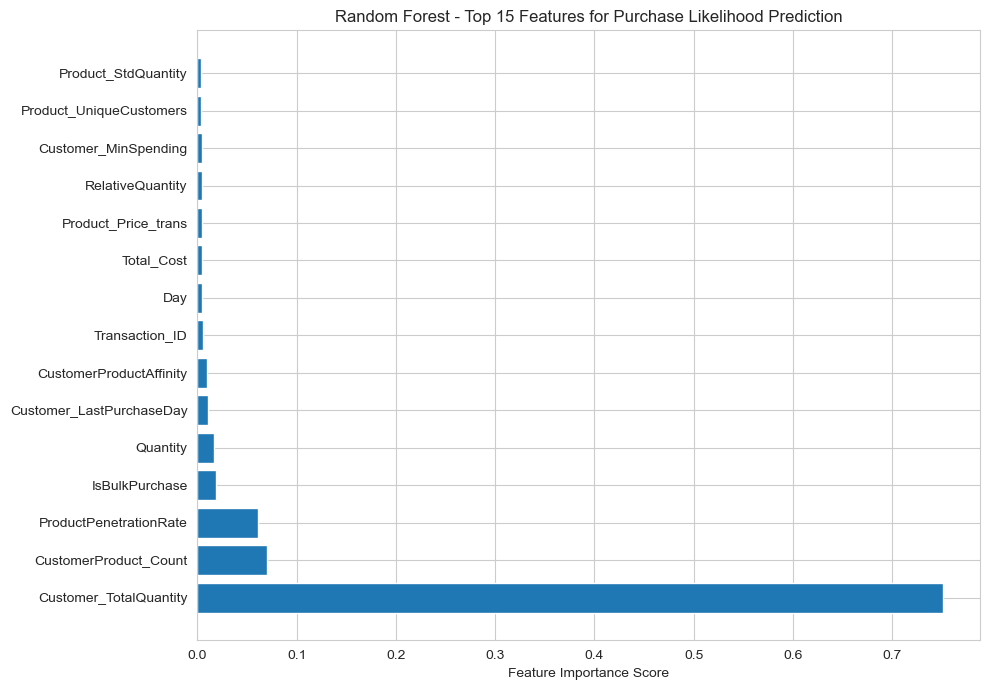


Total features analyzed: 33


In [22]:
# Visualize top 15 features
plt.figure(figsize=(10, 7))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance Score')
plt.title('Random Forest - Top 15 Features for Purchase Likelihood Prediction')
plt.tight_layout()
plt.show()

print(f"\nTotal features analyzed: {len(feature_importance)}")

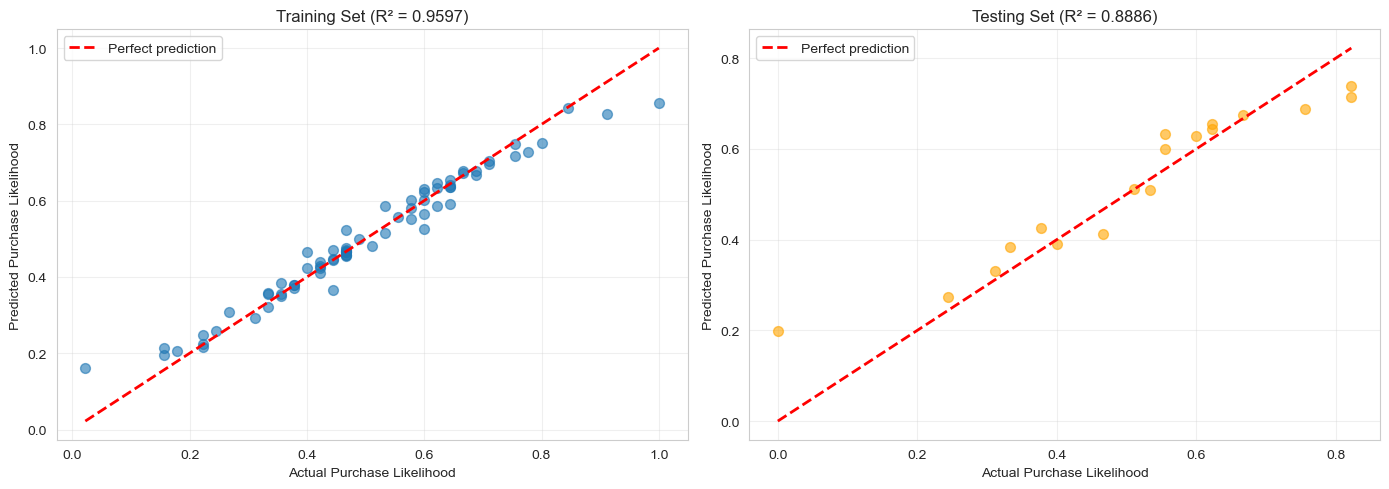

In [23]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Purchase Likelihood')
axes[0].set_ylabel('Predicted Purchase Likelihood')
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Testing set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Actual Purchase Likelihood')
axes[1].set_ylabel('Predicted Purchase Likelihood')
axes[1].set_title(f'Testing Set (R² = {test_r2:.4f})')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [25]:
# Predict for all customers
all_predictions = rf_model.predict(X)

# Create results dataframe
results = pd.DataFrame({
    'Company_ID': model_data['Company_ID'].values,
    'actual_purchase_likelihood': y.values,
    'predicted_purchase_likelihood': all_predictions,
    'prediction_error': np.abs(y.values - all_predictions)
})

# Sort by predicted likelihood
results = results.sort_values('predicted_purchase_likelihood', ascending=False)

print(f"\n" + "*"*80)
print("FINAL PREDICTIONS - ALL CUSTOMERS")
print("*"*80)
print(f"\nTotal customers predicted: {len(results)}")
print(f"\nTop 10 customers by predicted purchase likelihood:")
print(results.head(10).to_string(index=False))


********************************************************************************
FINAL PREDICTIONS - ALL CUSTOMERS
********************************************************************************

Total customers predicted: 90

Top 10 customers by predicted purchase likelihood:
 Company_ID  actual_purchase_likelihood  predicted_purchase_likelihood  prediction_error
         49                    1.000000                       0.856020          0.143980
         78                    0.844444                       0.843368          0.001076
         67                    0.911111                       0.827782          0.083329
         66                    0.800000                       0.749873          0.050127
         89                    0.755556                       0.749577          0.005979
         80                    0.822222                       0.739158          0.083064
         85                    0.777778                       0.726245          0.051532
        

In [26]:
print(f"\nBottom 10 customers by predicted purchase likelihood:")
print(results.tail(10).to_string(index=False))


Bottom 10 customers by predicted purchase likelihood:
 Company_ID  actual_purchase_likelihood  predicted_purchase_likelihood  prediction_error
          1                    0.244444                       0.273963          0.029519
         11                    0.244444                       0.258704          0.014259
         82                    0.222222                       0.247452          0.025230
         45                    0.222222                       0.223200          0.000977
         95                    0.222222                       0.217212          0.005010
         29                    0.155556                       0.213000          0.057444
         59                    0.177778                       0.206597          0.028819
         47                    0.000000                       0.199537          0.199537
         54                    0.155556                       0.194211          0.038655
         58                    0.022222                

In [27]:
# Save results
results.to_csv('milestone_1_purchase_likelihood_predictions.csv', index=False)
print(f"\n✓ Results saved to 'milestone_1_purchase_likelihood_predictions.csv'")


✓ Results saved to 'milestone_1_purchase_likelihood_predictions.csv'


In [30]:
print("\n" + "*"*80)
print("MILESTONE 1 - FINAL SUMMARY")
print("*"*80)

print(f"\n📊 PROJECT OVERVIEW:")
print(f"  Algorithm: Random Forest Regression")
print(f"  Objective: Predict customer's likelihood of making purchases")
print(f"  Target Scale: 0.0 (no purchases) to 1.0 (most likely to purchase)")

print(f"\n📈 DATA SUMMARY:")
print(f"  Total customers: {len(results)}")
print(f"  Features used: {X.shape[1]}")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"  Test R² Score: {test_r2:.4f} (explains {test_r2*100:.2f}% of variance)")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")

print(f"\n⭐ TOP 3 MOST IMPORTANT FEATURES:")
for i, (idx, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"  {i}. {row['feature']:30s} - {row['importance']:.4f}")

print(f"\n💾 OUTPUT FILES CREATED:")
print(f"  ✓ milestone_1_purchase_likelihood_predictions.csv")
print(f"    → Contains predictions for all {len(results)} customers")

print(f"\n" + "*"*80)
print(f"✓ MILESTONE 1 COMPLETE - READY FOR NEXT STEPS!")
print(f"*"*80)


********************************************************************************
MILESTONE 1 - FINAL SUMMARY
********************************************************************************

📊 PROJECT OVERVIEW:
  Algorithm: Random Forest Regression
  Objective: Predict customer's likelihood of making purchases
  Target Scale: 0.0 (no purchases) to 1.0 (most likely to purchase)

📈 DATA SUMMARY:
  Total customers: 90
  Features used: 33
  Training samples: 72
  Testing samples: 18

🎯 MODEL PERFORMANCE:
  Test R² Score: 0.8886 (explains 88.86% of variance)
  Test RMSE: 0.0681
  Test MAE: 0.0506

⭐ TOP 3 MOST IMPORTANT FEATURES:
  1. Customer_TotalQuantity         - 0.7510
  2. CustomerProduct_Count          - 0.0701
  3. ProductPenetrationRate         - 0.0612

💾 OUTPUT FILES CREATED:
  ✓ milestone_1_purchase_likelihood_predictions.csv
    → Contains predictions for all 90 customers

********************************************************************************
✓ MILESTONE 1 COMPLETE -

In [31]:
features_check = pd.read_csv('features_top30_scaled.csv')
print("Columns in features_top30_scaled.csv:")
print(features_check.columns.tolist())
print(f"\nShape: {features_check.shape}")
print(f"\nFirst row:\n{features_check.iloc[0]}")

Columns in features_top30_scaled.csv:
['Transaction_ID', 'Company_ID', 'Product_ID', 'CustomerProductAffinity', 'PricePerUnit', 'RelativePurchaseSize', 'Product_Price_prod', 'Product_TotalQuantitySold', 'Product_AvgQuantity', 'Product_StdRevenue', 'Product_StdQuantity', 'Product_AvgRevenue', 'Product_TotalRevenue', 'Product_TotalSales', 'Product_PopularityRank', 'Product_MarketShare', 'Quantity', 'Product_UniqueCustomers', 'RelativeQuantity', 'IsHighValueTransaction', 'Product_Price_trans', 'IsBulkPurchase', 'DiscountAmount', 'ProductPenetrationRate', 'Customer_MaxSpending', 'Customer_MinSpending', 'CustomerProduct_Count', 'Season_Encoded', 'Day', 'DiscountPercentage', 'Customer_LastPurchaseDay', 'Customer_TotalQuantity', 'DayOfWeek', 'Total_Cost']

Shape: (5818, 34)

First row:
Transaction_ID                1.000000
Company_ID                   88.000000
Product_ID                    6.000000
CustomerProductAffinity      -0.831813
PricePerUnit                 -0.395984
RelativePurchas